# Facial Recognition Model using One-shot Learning as an alternative to boarding fingerprint scanners

## Installation of Libraries Required

In [ ]:
pip install -U opencv-python numpy tensorflow==2.15.0

## Importing Libraries & Checking for Image Capturing Device

In [1]:
import os
import cv2
import random as rd
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from keras import *
from keras.layers import *
from keras import backend as K
from keras.models import Model
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import matplotlib.pyplot as plt
import sys
K.set_image_data_format('channels_last')

print(tf.__version__)


2.15.0


Setting the video capturing device and making sure that an input device is detected

In [2]:
cap=cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 480)

True

# Problem Statement

#### This project intends to provide an alternative to the fingerprint scanners at our boarding school by utilising a deep learning model for facial recognition with one-shot learning capabilities. The project only intends to cover the backend, and there will be no physical prototype. Hardware used for demonstration will be web camera from computer.

# If you are unable to run cells where files are loaded, replace the given file path with the absolute file path to the corresponding file and replace backslashes (\\) with forward slashes (/). 

# Data Collection

The way we intend to obtain our training data is to get a few images of the students and perform one-shot learning with them, such that we do not have to waste the students' time with gathering large quantities of pictures in different environments and conditions for each of them.

Firstly, we will be using the Opencv library to make use of the webcam as the input device, since we are not building a physical prototype. We also use a haar cascade classifier in order to detect whether there are faces in the webcam image. This chunk also checks if the cascade classifier was loaded correctly.

In [2]:
# This is the casecade classifier we will be using to detect whether a person is in any given image
facedetect=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Check if cascade classifier loaded (whether path to cascade classifier is valid)
if facedetect.empty():
    print("Error: Cascade Classifier not loaded")
else:
    print("Cascade Classifier loaded successfully")

Cascade Classifier loaded successfully


We then run this chunk where the user will be asked to input their name (not case-sensitive) and the webcam will start capturing images of the person if there is a face in the webcam. The images are then cropped such that only the face is visible in the image. 8 pictures total are taken of the student and saved to a folder which will be used for training and testing the model. 5 of which are for training (one of them script.jpg which will serve as the anchor image of each person when creating triplets for the second model using the triplet loss function), and 3 of them are for validation, which is used only for the first model.

In [4]:
# Use the first video capturing device on your device
video=cv2.VideoCapture(0)
count=0
contin = True
test = False
anchor = True

# Repeats until a valid name is entered, or the user escapes the process by entering nothing/pressing the escape key.
nameID=str(input("Enter Your Name: ")).lower()
while True:
	path='images/train/'+nameID
	path2='images/val/'+nameID
	isExist = os.path.exists(path)

	if len(nameID) == 0:
		print('Escape Detected. Ending Capture.')
		contin = False
		break

	# If name is already taken, ask for another one
	if isExist:
		print("Name Already Taken")
		nameID=str(input("Enter Your Name Again: ")).lower()
	else:
		os.makedirs(path)
		os.makedirs(path2)
		break


while contin:
	# Start reading input from webcam, shows webcam video capture on device
	ret,frame=video.read()
	# Detects all faces in image (in this case "frame")
	faces=facedetect.detectMultiScale(frame,1.3, 5)
	for x,y,w,h in faces:
		# Anchor image, which will be named script.jpg in the folders
		if not test and anchor:
			name='images/train/'+nameID+'/script.jpg'
			anchor = False
		elif not test and not anchor:
			name='images/train/'+nameID+'/'+ str(count) + '.jpg'
		else:
			name='images/val/'+nameID+'/'+ str(count) + '.jpg'
		count=count+1
		print("Creating Images..." +name)
		cv2.imwrite(name, frame[y:y+h,x:x+w])
		cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 3)
	cv2.imshow("WindowFrame", frame)
	cv2.waitKey(1)
	if not test and count>=5:
		test = True
		count = 0
		continue
	elif test and count>=3:
		break

# Stops reading input from webcam, removes webcam video capture on device
video.release()
cv2.destroyAllWindows()

Escape Detected. Ending Capture.


# Data Preprocessing

Since our data collection method already makes use of the cascade classifier to ensure that a face is in frame and crops the image down to one of a fixed size and of the face only, we do not need to preprocess the data or check for any images that are not relevant.

With our aim to perform one-shot learning, we will not be performing any data augmentation.

Since we want to minimise the number of false positives (we wouldn't want malicious ~~bad~~ actors getting into boarding would we?), we will be making our own custom precision metric in order to compare our models.

In [3]:
from keras import backend as K

def custom_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Creating a Model

For this project, we will create 2 models, one using transfer learning of MobileNet and the other being a model that is referencing FaceNet, and compare them.

## Deep Learning Model: MobileNet Transfer Learning CNN 

For this model, we will be using transfer learning on MobileNetV2, since this is what is the model supposedly used by teachablemachine (website that trains models for you based on data input, includes face recognition). However, since only the weights are given and the actual model summary is not given, we can only attempt to make our simple CNN model to emulate what is in teachable machine. Since we will be using a normal CNN so we will be splitting the training data using the normal method.

I originally wanted to use another pre-trained model like VGGFaceNet or others more suited for facial recognition, but I had troubles importing the models (likely due to them being old and so having issues with backwards compatability).

In [25]:
train = tf.keras.utils.image_dataset_from_directory('images/train', labels = 'inferred', image_size=(224, 224))
val = tf.keras.utils.image_dataset_from_directory('images/val', labels = 'inferred', image_size=(224, 224))

Found 10 files belonging to 2 classes.
Found 6 files belonging to 2 classes.


In [26]:
mobile_model = MobileNetV2(weights='imagenet', input_shape =  (224, 224, 3), include_top=False)
flat_layer = Flatten()(mobile_model.output)
dense_layer_1 = Dense(1024, activation='relu')(flat_layer)
normal_layer_1 = BatchNormalization()(dense_layer_1)
dense_layer_2 = Dense(1024, activation='relu')(normal_layer_1)
normal_layer_2 = BatchNormalization()(dense_layer_2)
dense_layer_3 = Dense(1024, activation='relu')(normal_layer_2)
normal_layer_3 = BatchNormalization()(dense_layer_3)
dense_layer_4 = Dense(256, activation='relu')(normal_layer_3)
normal_layer_4 = BatchNormalization()(dense_layer_4)
output_layer = Dense(3, activation='relu')(normal_layer_4)

for layer in mobile_model.layers:
    layer.trainable = False

transfer_mobile_model = Model(inputs = mobile_model.inputs, outputs = output_layer)

In [27]:
transfer_mobile_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_6[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

Based on some testing, this is the best number of epochs for training this model.

In [8]:
transfer_mobile_model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', custom_precision])

transferhistory = transfer_mobile_model.fit(train, validation_data=val, epochs=30)

Epoch 1/30


1/1 [==============================] - 4s 4s/step - loss: 1.1177 - accuracy: 0.4667 - custom_precision: 0.8462 - val_loss: 1.6157 - val_accuracy: 0.6667 - val_custom_precision: 0.6667
Epoch 2/30
1/1 [==============================] - 0s 371ms/step - loss: 0.2920 - accuracy: 0.8667 - custom_precision: 0.7222 - val_loss: 3.4128 - val_accuracy: 0.6667 - val_custom_precision: 0.6667
Epoch 3/30
1/1 [==============================] - 0s 364ms/step - loss: 0.1494 - accuracy: 0.9333 - custom_precision: 0.6429 - val_loss: 4.4670 - val_accuracy: 0.6667 - val_custom_precision: 0.7857
Epoch 4/30
1/1 [==============================] - 0s 357ms/step - loss: 0.0783 - accuracy: 0.9333 - custom_precision: 0.6429 - val_loss: 4.8726 - val_accuracy: 0.6667 - val_custom_precision: 0.7692
Epoch 5/30
1/1 [==============================] - 0s 363ms/step - loss: 0.0763 - accuracy: 0.9333 - custom_precision: 0.6429 - val_loss: 4.9968 - val_accuracy: 0.6667 - val_custom_precision: 0.8182
Epoch 6/30


## Deep Learning Model: Advanced CNN Model utilising Triplet Loss Function 

For the second model, we will be taking the model given in https://www.kaggle.com/code/amankumarmallik/one-shot-learning-for-face-verification, which aims to create a model which is able to perform one-shot learning for image recognition. It uses a triplet loss function which is where it differs from other models, taking in 3 images at a time. These 3 are the anchor, positive and negative images. The positive image is an image of the person in the anchor image. The negative image would then be an image of another person that is not the one in the anchor image. 

First, we want to create the triplets for the triplet loss function. The data_gen() function essentially pulls 2 random pictures of 1 person and another picture of a different person, reformats them using the localize_resize() function, and then outputs the triplet arrays.

In [4]:
def localize_resize(path_image,facedetect):
    image=cv2.imread(path_image)
    
    # Checks if the number of faces detected in the webcam frame is more than 1, it will not be used. 
    # However, due to the way we gathered the data, this should not be a problem and only serves as a contingency
    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    classifier= facedetect
    faces=classifier.detectMultiScale(gray,1.1,6)
    if len(faces) != 1: 
        return []
    
    # Crops images down to just the face
    x,y,w,h=faces.squeeze()
    crop=image[y:y+h,x:x+w]

    # Other reformatting 
    image=cv2.resize(crop,(96,96))
    image=image.astype('float32')/255.0 # makes pixel values between 0 and 1
    return image

def data_gen(batch_size=32):
    while True:
        count=0
        positive=[]
        anchor=[]
        negative=[]    
        
        # Generating the triplets
        while(count<batch_size):
            id=os.listdir('images/train')
            ra=rd.sample(id,2)
            pos_dir='images/train'+'/'+ra[0]
            neg_dir='images/train'+'/'+ra[1]
            pos=pos_dir+'/'+rd.choice(os.listdir(pos_dir))
            anc=pos_dir+'/'+rd.choice([x for x in os.listdir(pos_dir) if 'script' in x])
            neg=neg_dir+'/'+rd.choice(os.listdir(neg_dir))

            pos_img=localize_resize(pos,facedetect)
            if len(pos_img) == 0:
                continue
            neg_img=localize_resize(neg,facedetect)
            if len(neg_img) == 0:
                continue
            anc_img=localize_resize(anc,facedetect)
            if len(anc_img) == 0:
                continue
            
            positive.append(list(pos_img))
            negative.append(list(neg_img))
            anchor.append(list(anc_img))
            count=count+1
        yield ([np.array(anchor), np.array(positive), np.array(negative)], np.zeros((batch_size,1)).astype("float32"))

We then define the generator for future use.

In [5]:
# Generate a batch of data
data_generator = data_gen()
batch_data, batch_labels = next(data_generator)

We also want to visualise how the triplets look like.

Triplet 1:


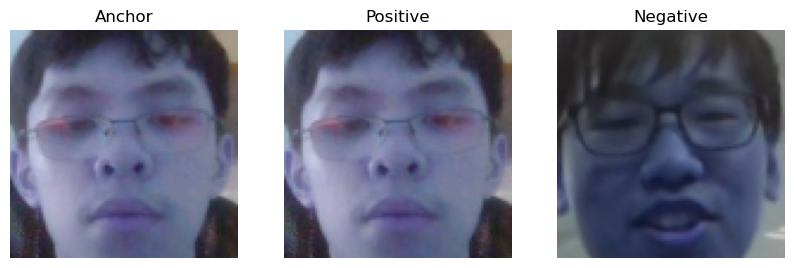

Triplet 2:


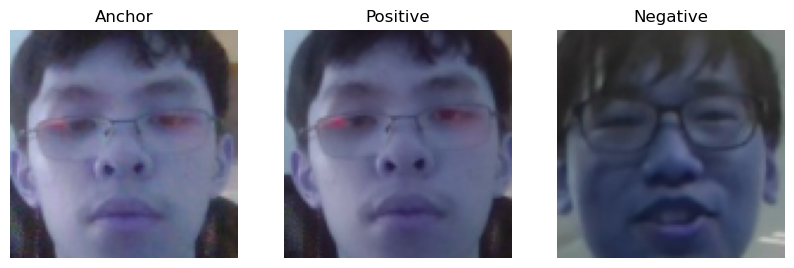

Triplet 3:


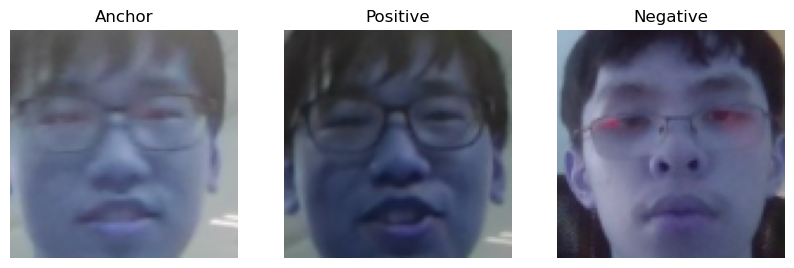

In [7]:
# Visualisation of triplets

# Print and visualize examples from each triplet
num_triplets_to_print = 3  # Number of triplets to print
for count in range(num_triplets_to_print):
    anchor, positive, negative = batch_data[0][count], batch_data[1][count], batch_data[2][count]
    print(f"Triplet {count + 1}:")
    
    # Display the anchor, positive, and negative images
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(anchor)
    axes[0].set_title('Anchor')
    axes[0].axis('off')
    axes[1].imshow(positive)
    axes[1].set_title('Positive')
    axes[1].axis('off')
    axes[2].imshow(negative)
    axes[2].set_title('Negative')
    axes[2].axis('off')
    plt.show()

Next, we have the base model which will be what actually actually generates the embeddings of the image.

In [6]:
def inception_block_1a(X):
    X_3=Conv2D(96,(1,1),data_format='channels_last',name='inception_3a_3x3_conv1')(X)
    X_3=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_3a_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_last')(X_3)
    X_3=Conv2D(128,(3,3),data_format='channels_last',name='inception_3a_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_3a_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    X_5=Conv2D(16,(1,1),data_format='channels_last',name='inception_3a_5x5_conv1')(X)
    X_5=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_3a_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_last')(X_5)
    X_5=Conv2D(32,(5,5),data_format='channels_last',name='inception_3a_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_3a_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_last')(X)
    X_pool = Conv2D(32, (1, 1), data_format='channels_last', name='inception_3a_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=-1, epsilon=0.00001, name='inception_3a_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=((3, 4), (3, 4)), data_format='channels_last')(X_pool)
    
    X_1=Conv2D(64,(1,1),data_format='channels_last',name='inception_3a_1x1_conv')(X)
    X_1=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_3a_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    
    inception=concatenate([X_3,X_5,X_pool,X_1],axis=3)
    return inception

def inception_block_1b(X):
    X_3=Conv2D(96,(1,1),data_format='channels_last',name='inception_3b_3x3_conv1')(X)
    X_3=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_3b_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_last')(X_3)
    X_3=Conv2D(128,(3,3),data_format='channels_last',name='inception_3b_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_3b_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    X_5=Conv2D(32,(1,1),data_format='channels_last',name='inception_3b_5x5_conv1')(X)
    X_5=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_3b_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_last')(X_5)
    X_5=Conv2D(64,(5,5),data_format='channels_last',name='inception_3b_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_3b_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    
    X_P=AveragePooling2D(pool_size=(3,3),strides=(3,3),data_format='channels_last')(X)
    X_P=Conv2D(64,(1,1),data_format='channels_last',name='inception_3b_pool_conv')(X_P)
    X_P=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_3b_pool_bn')(X_P)
    X_P=Activation('relu')(X_P)
    X_P=ZeroPadding2D(padding=(4,4),data_format='channels_last')(X_P)
    
    X_1=Conv2D(64,(1,1),data_format='channels_last',name='inception_3b_1x1_conv')(X)
    X_1=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_3b_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    
    inception=concatenate([X_3,X_5,X_P,X_1],axis=3)
    return inception

def inception_block_1c(X):
    X_3=Conv2D(128,(1,1),data_format='channels_last',name='inception_3c_3x3_conv1')(X)
    X_3=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_3c_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_last')(X_3)
    X_3=Conv2D(256,(3,3),strides=(2,2),data_format='channels_last',name='inception_3c_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_3c_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    X_5=Conv2D(32,(1,1),data_format='channels_last',name='inception_3c_5x5_conv1')(X)
    X_5=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_3c_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_last')(X_5)
    X_5=Conv2D(64,(5,5),strides=(2,2),data_format='channels_last',name='inception_3c_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_3c_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    
    X_P=MaxPooling2D(pool_size=3,strides=2,data_format='channels_last')(X)
    X_P=ZeroPadding2D(padding=((0,1),(0,1)),data_format='channels_last')(X_P)
    

    inception=concatenate([X_3,X_5,X_P],axis=3)
    return inception

def inception_block_2a(X):
    X_3=Conv2D(96,(1,1),data_format='channels_last',name='inception_4a_3x3_conv1')(X)
    X_3=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_4a_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_last')(X_3)
    X_3=Conv2D(192,(3,3),data_format='channels_last',name='inception_4a_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_4a_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    X_5=Conv2D(32,(1,1),data_format='channels_last',name='inception_4a_5x5_conv1')(X)
    X_5=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_4a_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_last')(X_5)
    X_5=Conv2D(64,(5,5),data_format='channels_last',name='inception_4a_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_4a_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    
    X_P=AveragePooling2D(pool_size=(3,3),strides=(3,3),data_format='channels_last')(X)
    X_P=Conv2D(128,(1,1),data_format='channels_last',name='inception_4a_pool_conv')(X_P)
    X_P=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_4a_pool_bn')(X_P)
    X_P=Activation('relu')(X_P)
    X_P=ZeroPadding2D(padding=(2,2),data_format='channels_last')(X_P)
    
    X_1=Conv2D(256,(1,1),data_format='channels_last',name='inception_4a_1x1_conv')(X)
    X_1=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_4a_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    
    inception=concatenate([X_3,X_5,X_P,X_1],axis=3)
    return inception

def inception_block_2b(X):
    X_3=Conv2D(160,(1,1),data_format='channels_last',name='inception_4e_3x3_conv1')(X)
    X_3=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_4e_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_last')(X_3)
    X_3=Conv2D(256,(3,3),strides=(2,2),data_format='channels_last',name='inception_4e_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=-1
    ,epsilon=0.00001,name='inception_4e_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    X_5=Conv2D(64,(1,1),data_format='channels_last',name='inception_4e_5x5_conv1')(X)
    X_5=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_4e_5x5_bn1')(X_5)
    X_5=Activation('relu')(X_5)
    X_5=ZeroPadding2D(padding=(2,2),data_format='channels_last')(X_5)
    X_5=Conv2D(128,(5,5),strides=(2,2),data_format='channels_last',name='inception_4e_5x5_conv2')(X_5)
    X_5=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_4e_5x5_bn2')(X_5)
    X_5=Activation('relu')(X_5)
    
    X_P=MaxPooling2D(pool_size=3,strides=2,data_format='channels_last')(X)
    X_P=ZeroPadding2D(padding=((0,1),(0,1)),data_format='channels_last')(X_P)

    inception=concatenate([X_3,X_5,X_P],axis=3)
    return inception

def inception_block_3a(X):
    X_3=Conv2D(96,(1,1),data_format='channels_last',name='inception_5a_3x3_conv1')(X)
    X_3=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_5a_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_last')(X_3)
    X_3=Conv2D(384,(3,3),data_format='channels_last',name='inception_5a_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_5a_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)

    
    X_P=AveragePooling2D(pool_size=(3,3),strides=(3,3),data_format='channels_last')(X)
    X_P=Conv2D(96,(1,1),data_format='channels_last',name='inception_5a_pool_conv')(X_P)
    X_P=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_5a_pool_bn')(X_P)
    X_P=Activation('relu')(X_P)
    X_P=ZeroPadding2D(padding=(1,1),data_format='channels_last')(X_P)
    
    X_1=Conv2D(256,(1,1),data_format='channels_last',name='inception_5a_1x1_conv')(X)
    X_1=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_5a_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    
    inception=concatenate([X_3,X_P,X_1],axis=3)
    return inception
def inception_block_3b(X):
    X_3=Conv2D(96,(1,1),data_format='channels_last',name='inception_5b_3x3_conv1')(X)
    X_3=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_5b_3x3_bn1')(X_3)
    X_3=Activation('relu')(X_3)
    X_3=ZeroPadding2D(padding=(1,1),data_format='channels_last')(X_3)
    X_3=Conv2D(384,(3,3),data_format='channels_last',name='inception_5b_3x3_conv2')(X_3)
    X_3=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_5b_3x3_bn2')(X_3)
    X_3=Activation('relu')(X_3)
    
    
    X_P=MaxPooling2D(pool_size=(3,3),strides=2,data_format='channels_last')(X)
    X_P=Conv2D(96,(1,1),data_format='channels_last',name='inception_5b_pool_conv')(X_P)
    X_P=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_5b_pool_bn')(X_P)
    X_P=Activation('relu')(X_P)
    X_P=ZeroPadding2D(padding=(1,1),data_format='channels_last')(X_P)
    
    X_1=Conv2D(256,(1,1),data_format='channels_last',name='inception_5b_1x1_conv')(X)
    X_1=BatchNormalization(axis=-1,epsilon=0.00001,name='inception_5b_1x1_bn')(X_1)
    X_1=Activation('relu')(X_1)
    
    inception=concatenate([X_3,X_P,X_1],axis=3)
    return inception


def FinalModel(input_shape):
    
    X_input=Input(input_shape)
    
    X=ZeroPadding2D(padding=(3,3))(X_input)
    X=Conv2D(64,(7,7),strides=(2,2),name='conv1')(X)
    X=BatchNormalization(axis=-1,name='bn1')(X)
    X=Activation('relu')(X)
    
    X=ZeroPadding2D((1,1))(X)
    X=MaxPooling2D((3,3),strides=2)(X)
    
    X=Conv2D(64,(1,1),strides=(1,1),name='conv2')(X)
    X=BatchNormalization(axis=-1,epsilon=0.00001,name='bn2')(X)
    X=Activation('relu')(X) 
    
    X=ZeroPadding2D(padding=(1,1))(X)
    
    X=Conv2D(192,(3,3),strides=(1,1),name='conv3')(X)
    X=BatchNormalization(axis=-1,epsilon=0.00001,name='bn3')(X)
    X=Activation('relu')(X)
    
    X=ZeroPadding2D(padding=(1,1))(X)
    X=MaxPooling2D(pool_size=(3,3),strides=(2,2))(X)
    
    X=inception_block_1a(X)
    X=inception_block_1b(X)
    X=inception_block_1c(X)
    
    X=inception_block_2a(X)
    X=inception_block_2b(X)
    
    X=inception_block_3a(X)
    X=inception_block_3b(X)
    
    X=AveragePooling2D(pool_size=(3,3),strides=(1,1),data_format='channels_last')(X)
    X=Flatten()(X)
    X=Dense(128,activation='relu',kernel_initializer='glorot_normal',name='dense_layer')(X)
    X=Lambda(lambda x:K.l2_normalize(x,axis=-1),name='lambda_1')(X)
    
    model=Model(inputs=X_input,outputs=X,name='FaceRecognotionModel')
    return model

In [7]:
model=FinalModel((96,96,3))

model.summary()



Model: "FaceRecognotionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 102, 102, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 48, 48, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 bn1 (BatchNormalization)    (None, 48, 48, 64)           256       ['conv1[0

Here, we will be defining the custom triplet loss function. We then wrap the base model with 3 input nodes and 1 output node, such that it can take in 3 images at a time.

In [8]:
def triplet_loss_t(y_true,y_pred):
    anchor=y_pred[:,0:128]
    pos=y_pred[:,128:256]
    neg=y_pred[:,256:384]
    
    positive_distance = K.sum(K.abs(anchor-pos), axis=-1)
    negative_distance = K.sum(K.abs(anchor-neg), axis=-1)
    probs=K.softmax([positive_distance,negative_distance],axis=0)
    loss=K.mean(K.abs(probs[0])+K.abs(1.0-probs[1]))
    return loss

triplet_model_a=Input((96,96,3))
triplet_model_n=Input((96,96,3))
triplet_model_p=Input((96,96,3))
triplet_model_out=Concatenate()([model(triplet_model_a),model(triplet_model_p),model(triplet_model_n)])
triplet_model=Model([triplet_model_a,triplet_model_p,triplet_model_n],triplet_model_out)
triplet_model.compile(optimizer='adam',loss=triplet_loss_t, metrics=['accuracy',custom_precision])
triplet_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 FaceRecognotionModel (Func  (None, 128)                  3743280   ['input_2[0][0]',             
 tional)                                                             'input_4[0][0]',        

Now we want to train our model. We first choose a few combinations of steps and epochs to train the model on. In order to train the model correctly, we need to rerun the above code each time we want to fit the model based on a different number of steps and epochs.

In [28]:
triplet_model.fit(data_generator, steps_per_epoch=10,epochs=10)
triplet_model.save('triplet_model_10step_10epoch.h5')

Epoch 1/10
10/10 [==============================] - 82s 8s/step - loss: 5.2006 - accuracy: 0.3063 - custom_precision: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 95s 9s/step - loss: 4.9640 - accuracy: 0.5250 - custom_precision: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 90s 9s/step - loss: 4.9640 - accuracy: 0.6750 - custom_precision: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 87s 9s/step - loss: 4.9640 - accuracy: 0.6469 - custom_precision: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 88s 9s/step - loss: 4.9640 - accuracy: 0.7719 - custom_precision: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 98s 10s/step - loss: 4.9640 - accuracy: 0.5594 - custom_precision: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 91s 9s/step - loss: 4.9640 - accuracy: 0.5437 - custom_precision: 0.0000e+00
Epoch 8/10
10/10 [==============================] - 97s 9s/step - loss: 4.9640 - accuracy: 0.521

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
triplet_model.fit(data_generator, steps_per_epoch=32,epochs=1)
triplet_model.save('triplet_model_32step_1epoch.h5')

32/32 [==============================] - 297s 10s/step - loss: 4.9640 - accuracy: 0.7363 - custom_precision: 0.0000e+00


In [12]:
triplet_model.fit(data_generator, steps_per_epoch=100,epochs=10)
triplet_model.save('triplet_model_100step_10epoch.h5')

Epoch 1/10
100/100 [==============================] - 391s 4s/step - loss: 5.4620 - accuracy: 0.4087 - custom_precision: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 443s 4s/step - loss: 5.4762 - accuracy: 0.4166 - custom_precision: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 1200s 12s/step - loss: 5.4690 - accuracy: 0.3922 - custom_precision: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 404s 4s/step - loss: 5.4602 - accuracy: 0.3941 - custom_precision: 0.0000e+00
Epoch 5/10
100/100 [==============================] - 446s 4s/step - loss: 5.4684 - accuracy: 0.4328 - custom_precision: 0.0000e+00
Epoch 6/10
100/100 [==============================] - 957s 10s/step - loss: 5.4846 - accuracy: 0.3925 - custom_precision: 0.0000e+00
Epoch 7/10
100/100 [==============================] - 767s 8s/step - loss: 5.4484 - accuracy: 0.3947 - custom_precision: 0.0000e+00
Epoch 8/10
100/100 [==============================] - 434s 4s/step - loss

/opt/anaconda3/envs/machinelearning/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluation of Models

In order to compare our models, we will be using accuracy and precision of our models to compare them (explained in data collection). We will also be using each model and attempting to classify faces detected in our webcam in real-time to to simulate a real world scenario. However, if you look at the metrics above for the second type of model, something strange seems to be happening. The precision of the models is always 0?

This is because the second type of model generates embeddings. Since we are unable to view the accuracy and precision of the triplet loss function models, we will be generating a new batch, encoding and comparing them in order to get the precision and accuracy of the second type of models.

Firstly, we generate a new batch of data and set the threshold value for the similarity between 2 encoded images.

In [9]:
threshold=0.75
interval=0.3
test_data, unneeded = next(data_gen())

Then, we define the functions we will be using to encode the image using the model and compare to images to find how similar they are.

In [10]:
def encode_img(img1,triplet_model):
    img=img1[...,::-1]
    x_train=np.array([img])
    emb=triplet_model.layers[3].predict_on_batch(x_train)
    return emb

In [11]:
def confidence_value(ref_encode,img_encode,thres=threshold):
    dist=np.linalg.norm((img_encode-ref_encode))
    confidence=(threshold-max([dist,interval]))/(threshold-interval)
    return dist,confidence

Finally, we make a function to create a confusion matrix of our results. This confusion matrix is not the usual predicted classes vs actual classes, but rather a linear summation of all such possible confusion matrices of the given classes.

In [33]:
def calcmatrix(data, trip_model):
    posresults, negresults = [], []
    batch_size = data[0].shape[0]
    for i in range(batch_size):
        pos_test = 1 if confidence_value(encode_img(data[0][i], trip_model), encode_img(data[1][i], trip_model))[0]<threshold else 0
        posresults.append(pos_test)
        neg_test = 0 if confidence_value(encode_img(data[0][i], trip_model), encode_img(data[2][i], trip_model))[0]<threshold else 1
        negresults.append(neg_test)

    TP, FN = posresults.count(1), posresults.count(0)
    TN, FP = negresults.count(1), negresults.count(0)
    return np.array([[TP,FN], [FP, TN]])

# TODO: Change which model you want to load here
matrix_loaded_model = keras.models.load_model('triplet_model_100step_10epoch.h5',custom_objects={'triplet_loss_t':triplet_loss_t, 'custom_precision': custom_precision})
confmatrix = calcmatrix(test_data, matrix_loaded_model)

# Matrix in the format of:
# TP FP
# FP TN
confmatrix

array([[32,  0],
       [ 0, 32]])

Using the confusion matrix, we are now able to calculate the accuracy and precision of the models. 

In [34]:
def calcacc(matrix):
    return (matrix[0][0] + matrix [1][1]) / np.sum(matrix)

def calcprec(matrix):
    return matrix[0][0] / (matrix[0][0] + matrix[1][0])

print(f"The accuracy of the chosen model {round(calcacc(confmatrix), 6)} and the precision of the chosen model is {round(calcprec(confmatrix), 6)}.")

The accuracy of the chosen model 1.0 and the precision of the chosen model is 1.0.


Now, we want to compare how our models would fare in a real world scenario. In order to emulate that, we will be testing how the model classifies the faces in the webcam. Firstly, we load up the list of people that the models are trained on.

In [12]:
labels = next(os.walk("images/train"))[1]
labels

['aik lok', 'yew']

Since we cannot simply use .predict() for the second type of models, the code will differ slightly for each type. The reason for not checking if a percentage of predictions is above a set threshold within any set time period is due to the possiblity that the model will predict a different output given the same face is unlikely.

It should also be noted that this implementation only checks for 1 specific face, so it does not account for the possibility of someone walking away and another person attempting to use the lock or other such cases, since this is only a test for how the models would fare given a set environment. However, it would be possible to modify the code below for a more general use case (though it still would not match up in real life since we are not using a laptop webcam)

In [ ]:
model = transfer_mobile_model
timenow = datetime.now()
cont = True
video=cv2.VideoCapture(0)
video.set(3, 640)
video.set(4, 480)
while cont:
	# Start reading input from webcam, shows webcam video capture on device
	success, imgOrignal=video.read()
	# Detects all faces in image (in this case "imgOriginal")
	faces = facedetect.detectMultiScale(imgOrignal,1.3,5)
	for x,y,w,h in faces:
		# Crops webcam frame down to just the face
		crop_img=imgOrignal[y:y+h,x:x+h]
		img=cv2.resize(crop_img, (224,224))
		
		# Reshaping to fit model input format and predicting which person it is
		img=img.reshape(1, 224, 224, 3)
		prediction=model.predict(img)
		classIndex = np.argmax(prediction)

		# Draws a rectangle and text around the face in the webcam view to show that a person is detected
		cv2.rectangle(imgOrignal,(x,y),(x+w,y+h),(0,255,0),2)
		cv2.rectangle(imgOrignal, (x,y-40),(x+w, y), (0,255,0),-2)
		cv2.putText(imgOrignal, labels[classIndex],(x,y-10), cv2.FONT_HERSHEY_COMPLEX, 0.75, (255,255,255),1, cv2.LINE_AA)
		
		# After ensuring that face is in image for a certain length of time, authenticate them and let them in
		if (datetime.now() - timenow).total_seconds() * 1000 > 1500: #1500ms or 1.5s
			print(f'{labels[classIndex]} detected. Welcome.')
			cont = False
			break
		
	cv2.imshow("WindowFrame", imgOrignal)
	k=cv2.waitKey(1)
	if k==ord('q'):
		break
video.release()
cv2.destroyAllWindows()

Now, we need to make a custom function to predict images using the triplet models by comparing the face to each of the faces the model has been trained on.

In [13]:
# Used for images loaded from files using CV2
def image_resizing(image,facedetect):

    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    classifier=facedetect
    faces=classifier.detectMultiScale(gray,1.1,6)

    if len(faces)!=1:
        print('More than one Image in the selfie')
        sys.exit(0)
    x,y,w,h=faces.squeeze()
    crop=image[y:y+h,x:x+w]
    image=cv2.resize(crop,(96,96))

    return image

In [23]:
def predict_img(image, trip_model):
    dist, conf = [], []
    image_encode = encode_img(image, trip_model)
    for name in labels:
        rimage=cv2.imread(f'images/train/{name}/script.jpg')
        img=image_resizing(rimage,facedetect)
        r_encode=encode_img(img,trip_model)

        dist.append((confidence_value(r_encode, image_encode))[0])
        conf.append((confidence_value(r_encode, image_encode))[0])

    lowdist = min(dist)
    lowconf = conf[dist.index(lowdist)]

    if lowdist<threshold and lowconf>85:
        return labels[dist.index(lowdist)]
    else:
        return None

In [ ]:
# TODO: Change which model you want to load here
model = keras.models.load_model('triplet_model_100step_10epoch.h5',custom_objects={'triplet_loss_t':triplet_loss_t,'custom_precision':custom_precision})
timenow = datetime.now()
cont = True
video=cv2.VideoCapture(0)
video.set(3, 640)
video.set(4, 480)
while cont:
	# Start reading input from webcam, shows webcam video capture on device
	success, imgOrignal=video.read()
	# Detects all faces in image (in this case "imgOriginal")
	faces = facedetect.detectMultiScale(imgOrignal,1.3,5)
	for x,y,w,h in faces:
		# Crops webcam frame down to just the face
		crop_img=imgOrignal[y:y+h,x:x+h]
		img=cv2.resize(crop_img, (96,96))
		
		# Reshaping to fit model input format and predicting which person it is
		prediction = predict_img(img, model)

		# Draws a rectangle and text around the face in the webcam view to show that a person is detected
		cv2.rectangle(imgOrignal,(x,y),(x+w,y+h),(0,255,0),2)
		cv2.rectangle(imgOrignal, (x,y-40),(x+w, y), (0,255,0),-2)
		cv2.putText(imgOrignal, prediction,(x,y-10), cv2.FONT_HERSHEY_COMPLEX, 0.75, (255,255,255),1, cv2.LINE_AA)
		
		# After ensuring that face is in image for a certain length of time, authenticate them and let them in
		if (datetime.now() - timenow).total_seconds() * 1000 > 1500 and prediction != None: #1500ms or 1.5s
			print(f'{prediction} detected. Welcome.')
			cont = False
			break
		else:
			print('None detected..?')
			timenow = datetime.now()
		
	cv2.imshow("WindowFrame", imgOrignal)
	k=cv2.waitKey(1)
	if k==ord('q'):
		break
video.release()
cv2.destroyAllWindows()

# Hyperparameter Tuning

Since our model is so complicated, and the training time is too long, in the interest of time we will not be hyperparameter tuning the model.

# Model Evaluation & Conclusion

As you can see from above, there were several issues with our models. In terms of accuracy and precision metrics, we can see that the accuracy and precision on validation both claim to be two-thirds exactly for the first model type and the accuracy and precision is 1.0 for the second one.

Doing some testing using the webcams and code cells reveals that for the first model type, it always predicts the opposite class, and for the second model type, it always has low confidence values and low distance values.

Overall, we have no idea why the models are having these issues. The possible explanations we could come up with are:
- For the first model type, we are using mobilenet rather than another model that is trained on faces specifically and is more suited for such a use case. Unfortunately, when I tried to use them, there were some issues with importing of libraries which likely stems from backwards compatibility issues.
- For the second model type, it is likely due to the way we collected the data (since the reference also had a low number of training data, but the images were higher resolution, in better lighting and always differed in environment), or maybe the way we reformatted the data before training/predicting using the data.